# Example : KAN discovering formulas

The orignal Kolmogorov-Arnold theorem says that it suffices to have 2-Layer function composition (inner and outer functions), but the functions might be non-smooth or even fractal. 
 
Number of layers can be decided by the complexity of the function to be discovered. For example, a 3-layer KAN can discover the Feyman Relativistic Velocity Addition formula:
$$\frac{u + v}{1 + uv}$$



Remember I must have it decomposed in univariate functions. So I can write the above function as:
$$ uv \rightarrow 2uv = (u + v)^2 - (u^2 + v^2)$$
that needs 2 layers: in the firse we compute square and a constant, and in the second we compute the square of the constants and constant of the squared terms.
Let's see if how KAN can discover this function.

train loss: 1.32e-02 | test loss: 1.35e-02 | reg: 4.55e+00 : 100%|██| 20/20 [00:03<00:00,  6.21it/s]


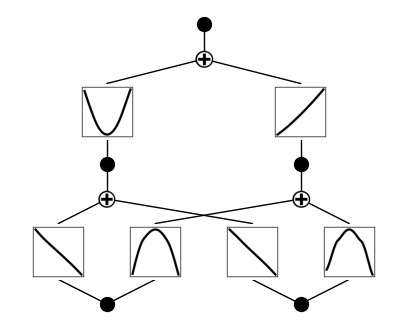

In [77]:
import numpy as np
from kan import KAN, create_dataset
model = KAN(width=[2,2,1], grid=4, k=2, seed=2)
f = lambda x: (x[:,[0]] * x[:,[1]])
dataset = create_dataset(f, n_var=2, train_num=3000)
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.)
model.plot(beta=10)

In [78]:
model.suggest_symbolic(1,0,0)

   function  fitting r2    r2 loss  complexity  complexity loss  total loss
0       sin    0.999737 -11.837051           2                2   -0.767410
1       cos    0.999670 -11.521541           2                2   -0.704308
2       x^2    0.997866  -8.865302           2                2   -0.173060
3         0    0.000000   0.000014           0                0    0.000003
4  gaussian    0.999722 -11.759277           3                3    0.048145


('sin',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9997366666793823,
 2)

r2 is 0.9978657364845276


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

train loss: 9.17e-03 | test loss: 9.13e-03 | reg: 4.42e+00 : 100%|██| 20/20 [00:03<00:00,  6.27it/s]


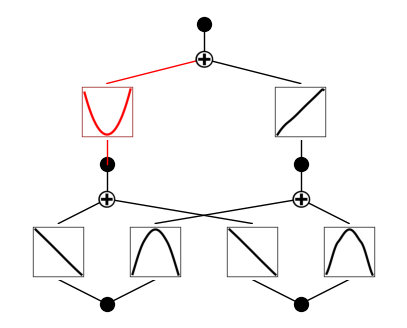

In [79]:
model.fix_symbolic(1, 0, 0, 'x^2')
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.)
model.plot(beta=10)

Best value at boundary.
r2 is 0.9999486804008484
r2 is 0.9996417760848999
Best value at boundary.
r2 is 0.9999474883079529
r2 is 0.9971017837524414
r2 is 1.0000001192092896
r2 is 0.9995747208595276


train loss: 3.26e-03 | test loss: 3.32e-03 | reg: 4.44e+00 : 100%|██| 20/20 [00:00<00:00, 31.06it/s]


([-0.518255428635218*(-x_1 - 0.00256214334098779)**2 - 0.466256683768766*(-x_2 - 0.00317006703126875)**2 + 0.522716742206851*(x_1 + 0.948718330747934*x_2 + 0.00281703793837165)**2 - 0.00285778076406373],
 [x_1, x_2])

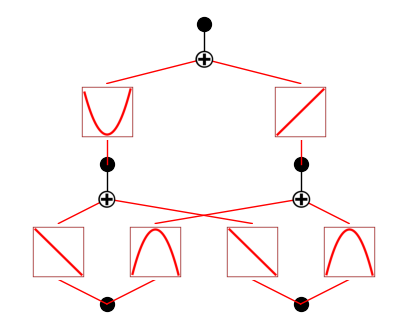

In [80]:
model.fix_symbolic(0, 0, 0, 'x') # layer 0 neuron 0 out_neuron 0
model.fix_symbolic(0, 0, 1, 'x^2')
model.fix_symbolic(0, 1, 0, 'x')
model.fix_symbolic(0, 1, 1, 'x^2')

model.fix_symbolic(1, 0, 0, 'x^2')
model.fix_symbolic(1, 1, 0, 'x')

model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.)

model.plot(beta=10)
model.symbolic_formula()

# KAN autodiscover 
 - What if we don't know the structure we need a priori?
 - KAN autodiscover: we can start with a wider and deeper network, and then prune it.

   1) set a width, train multiple nework without pruning, using different number of layers, take the best performing (Pareto Frontiers).
   2) train the best performing network with sparsification and auto-pruning, using a different number of Grids.
   3) Fit symbolic functions

If we try to do it on the Feyman Relativistic Velocity Addition formula:
$$\frac{u + v}{1 + uv}$$
we expect that:
- $uv$ will need 2 layers, 
- inversion of $(1 + uv)$ will need 1 layer,
- multiplication of $uv$ by $\frac{1}{1 + uv}$ will need again 2 layers,

a total of 5 layers.

But surprisingly *KAN-Autodiscover method* gets its minumum using 2 layers 


train loss: 2.63e-02 | test loss: 2.70e-02 | reg: 3.98e+00 : 100%|██| 20/20 [00:01<00:00, 10.81it/s]


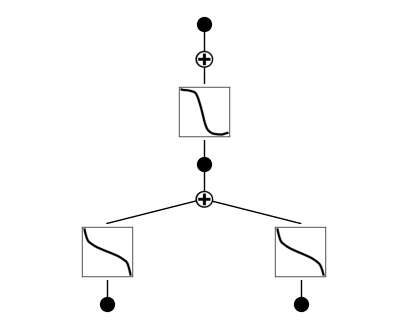

In [54]:
model = KAN(width=[2,1,1], grid=10, k=2, seed=0)
f = lambda x: (( x[:, [0]] + x[:,[1]])/(1 + x[:,[0]] * x[:,[1]]))
dataset = create_dataset(f, n_var=2, train_num=3000)
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.)
model.plot(beta=10)

In [55]:
type(model)

kan.MultKAN.MultKAN

# Does it make sense?
Absolutely yes: the formula can be seen in another way:
$$\frac{u + v}{1 + uv} = tanh(arctanh(u) + arctanh(v))$$

in a way called *addition in rapidity space*


  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.929041 -3.816662           1                1    0.036668
2      tan    0.997251 -8.501438           3                3    0.699712
3    x^0.5    0.932376 -3.886104           2                2    0.822779
4     sqrt    0.932376 -3.886104           2                2    0.822779


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

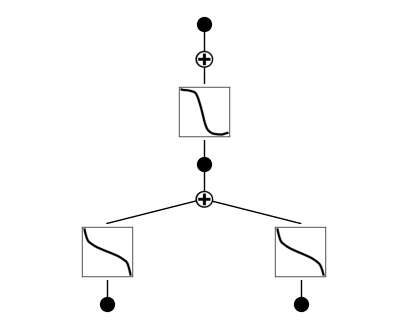

In [60]:
# lock ids in the l-th layer to be the same function
#model.lock(0,[[0,0],[1,0]])
model.plot(beta=10)
model.suggest_symbolic(0,0,0)

In [61]:
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.)

train loss: 2.56e-02 | test loss: 2.69e-02 | reg: 3.77e+00 : 100%|██| 20/20 [00:02<00:00,  9.13it/s]


{'train_loss': [array(0.02647668, dtype=float32),
  array(0.02633417, dtype=float32),
  array(0.0262694, dtype=float32),
  array(0.0262524, dtype=float32),
  array(0.02624252, dtype=float32),
  array(0.02632645, dtype=float32),
  array(0.02648619, dtype=float32),
  array(0.02618546, dtype=float32),
  array(0.0252919, dtype=float32),
  array(0.0250882, dtype=float32),
  array(0.02635589, dtype=float32),
  array(0.02628539, dtype=float32),
  array(0.02627161, dtype=float32),
  array(0.02621264, dtype=float32),
  array(0.02618099, dtype=float32),
  array(0.02622648, dtype=float32),
  array(0.02600001, dtype=float32),
  array(0.02575681, dtype=float32),
  array(0.02559725, dtype=float32),
  array(0.02559995, dtype=float32)],
 'test_loss': [array(0.02844855, dtype=float32),
  array(0.02779962, dtype=float32),
  array(0.0280596, dtype=float32),
  array(0.02778038, dtype=float32),
  array(0.02787587, dtype=float32),
  array(0.02783145, dtype=float32),
  array(0.02732564, dtype=float32),
  arr

In [62]:
model.suggest_symbolic(1,0,0)

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.894230 -3.240864           1                1    0.151827
2      cos    0.935192 -3.947461           2                2    0.810508
3      sin    0.935188 -3.947362           2                2    0.810528
4      x^2    0.894368 -3.242746           2                2    0.951451


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

# Loss and multidimensional output

- The loss used is MSE, but we can pass to the training function a custom loss.

- The output can be multidimensional, and the model will try to discover a formula for each output.

- Lets' see an example with a 2D output.

train loss: 2.63e-02 | test loss: 2.70e-02 | reg: 3.98e+00 : 100%|██| 20/20 [00:02<00:00,  8.26it/s]


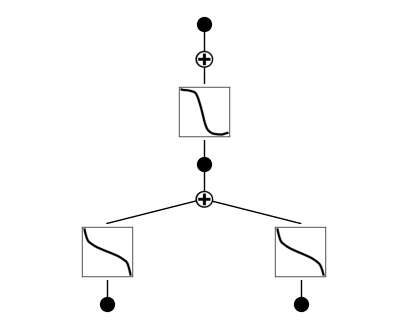

In [63]:
model = KAN(width=[2,1,1], grid=10, k=2, seed=0)
f = lambda x: (( x[:, [0]] + x[:,[1]])/(1 + x[:,[0]] * x[:,[1]]))
dataset = create_dataset(f, n_var=2, train_num=3000)
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.)
model.plot(beta=10)

In [64]:
model.auto_symbolic()
model.symbolic_formula()

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,1,0) with x, r2=0.9381147623062134, c=1
fixing (1,0,0) with 0, r2=0.0, c=0


([-0.0100678959861398], [x_1, x_2])

In [65]:
dataset = create_dataset(f, n_var=2, train_num=3000)

In [66]:
import torch
dataset["test_label"] = torch.cat([dataset["test_label"], -1 * dataset["test_label"]], dim=1)
dataset["train_label"] = torch.cat([dataset["train_label"], -1 * dataset["train_label"]], dim=1)

In [67]:
dataset["train_label"]

tensor([[ 0.4918, -0.4918],
        [ 0.3162, -0.3162],
        [-0.1797,  0.1797],
        ...,
        [ 0.0876, -0.0876],
        [-0.1826,  0.1826],
        [-0.4140,  0.4140]])

train loss: 4.26e-02 | test loss: 4.46e-02 | reg: 6.68e+00 : 100%|██| 50/50 [00:09<00:00,  5.31it/s]


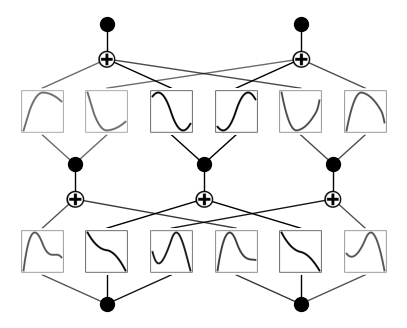

In [68]:
model = KAN(width=[2, 3, 2], grid=2, k=2, seed=0)
results = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, lamb_entropy=2.)
model.plot(beta=10)

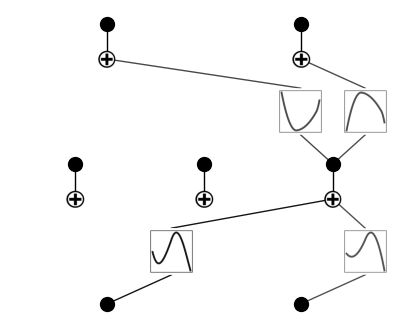

In [69]:
model.remove_node(1,1)
model.remove_node(1,0)
model.plot(beta=10)

train loss: 2.86e-01 | test loss: 2.94e-01 | reg: 6.83e+00 : 100%|████| 2/2 [00:00<00:00,  7.22it/s]


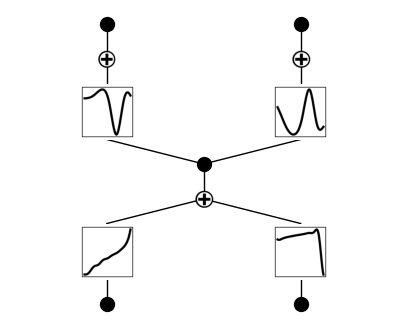

In [72]:
model = KAN(width=[2, 1, 2], grid=10, k=3, seed=0)
results = model.fit(dataset, opt="LBFGS", steps=2, lamb=0.001, lamb_entropy=2.)
model.plot(beta=10)